Importing the libraries

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Suppress TensorFlow logging and Keras warnings for a cleaner output
tf.get_logger().setLevel('ERROR')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

Read the Dataset


In [28]:
df=pd.read_csv('Data.csv')

Data Preparation

In [29]:
print("--- Initial Data Snapshot (Simulated Data) ---")
print(df.head())
print("-" * 60)

--- Initial Data Snapshot (Simulated Data) ---
   Id                                  Sentence    Target
0   1                  The classroom was a zoo.  Metaphor
1   2       The stars were diamonds in the sky.  Metaphor
2   3  Time is a thief that steals our moments.  Metaphor
3   4        Life is a journey with many paths.  Metaphor
4   5          Her mind was a maze of thoughts.  Metaphor
------------------------------------------------------------


Handling Missing Values

In [30]:
# --- 2. Data Preparation ---

# a) Handling missing values
print("Checking for missing values:")
print(df.isnull().sum())
# Drop rows where Sentence or Target might be missing
df.dropna(subset=['Sentence', 'Target'], inplace=True)
print(f"\nDataFrame size after dropping NaNs: {len(df)}")

Checking for missing values:
Id          0
Sentence    0
Target      0
dtype: int64

DataFrame size after dropping NaNs: 391


Handling categorical data

In [31]:
# b) Handling categorical data (Target column) using LabelEncoder
le = LabelEncoder()
df['Target_Encoded'] = le.fit_transform(df['Target'])

In [32]:
# Determine the mapping: Simile (1) and Metaphor (0)
target_names = le.classes_
target_map = {name: le.transform([name])[0] for name in target_names}
print(f"\nTarget Mapping (LabelEncoder): {target_map}")
# For binary classification, Simile is likely mapped to 1 (positive class) and Metaphor to 0.


Target Mapping (LabelEncoder): {'Metaphor': 0, 'Simile': 1}


In [33]:
# --- 3. TF-IDF Vectorization ---
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X = tfidf.fit_transform(df['Sentence']).toarray()
y = df['Target_Encoded'].values

print(f"\nTF-IDF Matrix Shape (X): {X.shape}")


TF-IDF Matrix Shape (X): (391, 480)


Splitting data into train and test

In [34]:
# --- 4. Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [35]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print("-" * 60)

X_train shape: (312, 480)
X_test shape: (79, 480)
------------------------------------------------------------


Logistic regression

In [36]:
# --- 5. Logistic Regression (Baseline) ---
print("--- Training Logistic Regression Model ---")
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

--- Training Logistic Regression Model ---


LogisticRegression(max_iter=1000)

In [37]:
# Evaluation
lr_pred = lr_model.predict(X_test)
print("\nLogistic Regression Classification Report on Test Set:")
# target_names is correctly ['Metaphor', 'Simile'] based on alphabetical order and LabelEncoder
print(classification_report(y_test, lr_pred, target_names=target_names, zero_division=0))
print("-" * 60)


Logistic Regression Classification Report on Test Set:
              precision    recall  f1-score   support

    Metaphor       0.75      0.28      0.41        32
      Simile       0.66      0.94      0.77        47

    accuracy                           0.67        79
   macro avg       0.70      0.61      0.59        79
weighted avg       0.69      0.67      0.62        79

------------------------------------------------------------


 ANN(artificial neural network)

In [38]:
# --- 6. Artificial Neural Network (ANN) ---

# Build the Neural Network Model
# NOTE: The requested Dropout(6.5) was corrected to Dropout(0.5) as dropout rates must be between 0 and 1.
input_dim = X_train.shape[1]

model = Sequential([
    # Input Layer (implicitly defined by input_shape in the first Dense layer)
    Dense(512, activation='relu', input_shape=(input_dim,)),
    Dropout(0.5), # Regularization to prevent overfitting
    Dense(256, activation='relu'),
    Dropout(0.5), # Regularization to prevent overfitting
    # Output layer for binary classification (Simile/Metaphor)
    Dense(1, activation='sigmoid')
])

In [39]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [40]:
# Print model summary
print("--- ANN Model Summary ---")
model.summary()
print("-" * 60)

--- ANN Model Summary ---
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 512)               246272    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 377857 (1.44 MB)
Trainable params: 377857 (1.44 MB)
Non-trainable params: 0 (0.00 Byte)
__________________________________________________________

In [41]:
# Train the model
print("\n--- Training ANN Model (Epochs=75, Batch Size=64, Verbose=2) ---")
history = model.fit(
    X_train, y_train,
    epochs=150,
    batch_size=64,
    verbose=2, # Verbose=2 prints one line per epoch
    validation_data=(X_test, y_test)
)
print("-" * 60)


--- Training ANN Model (Epochs=75, Batch Size=64, Verbose=2) ---
Epoch 1/150
5/5 - 1s - loss: 0.7013 - accuracy: 0.4231 - val_loss: 0.6947 - val_accuracy: 0.4304 - 522ms/epoch - 104ms/step
Epoch 2/150
5/5 - 0s - loss: 0.6989 - accuracy: 0.4391 - val_loss: 0.6925 - val_accuracy: 0.5696 - 47ms/epoch - 9ms/step
Epoch 3/150
5/5 - 0s - loss: 0.6922 - accuracy: 0.4808 - val_loss: 0.6904 - val_accuracy: 0.5696 - 63ms/epoch - 13ms/step
Epoch 4/150
5/5 - 0s - loss: 0.6933 - accuracy: 0.4936 - val_loss: 0.6884 - val_accuracy: 0.6076 - 47ms/epoch - 9ms/step
Epoch 5/150
5/5 - 0s - loss: 0.6875 - accuracy: 0.5994 - val_loss: 0.6866 - val_accuracy: 0.6076 - 36ms/epoch - 7ms/step
Epoch 6/150
5/5 - 0s - loss: 0.6836 - accuracy: 0.6346 - val_loss: 0.6849 - val_accuracy: 0.5949 - 55ms/epoch - 11ms/step
Epoch 7/150
5/5 - 0s - loss: 0.6790 - accuracy: 0.6506 - val_loss: 0.6833 - val_accuracy: 0.5949 - 37ms/epoch - 7ms/step
Epoch 8/150
5/5 - 0s - loss: 0.6829 - accuracy: 0.5833 - val_loss: 0.6818 - val_ac

In [42]:

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\nANN Final Test Loss: {loss:.4f}")
print(f"ANN Final Test Accuracy: {accuracy:.4f}")
print("-" * 60)


ANN Final Test Loss: 0.5440
ANN Final Test Accuracy: 0.7722
------------------------------------------------------------



--- Training Accuracy Plot (Generated Image of Training Accuracy and Validation) ---


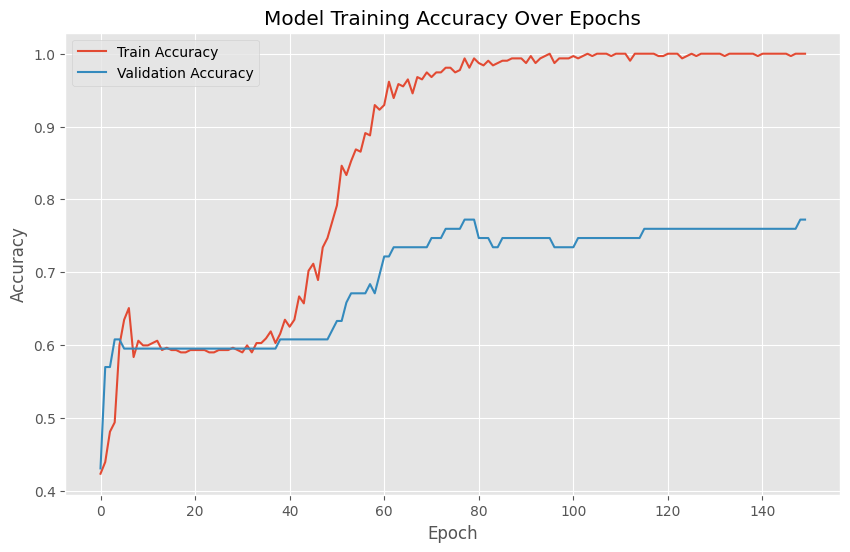

In [43]:
# Plot training accuracy
print("\n--- Training Accuracy Plot (Generated Image of Training Accuracy and Validation) ---")
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Training Accuracy Over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.style.use('ggplot')

Test the model

In [44]:
# --- 7. Test the model with example sentences ---
example_sentences = [
    "The world is a stage, a stage where every man must play a part.",
    "Brave as a lion, he faced the fierce dragon.",
    "Poverty is the greatest enemy of human happiness.",
    "He runs like the wind, always finishing first in the race."
]

In [45]:
print("\n--- Testing Model with New Example Sentences ---")
# Vectorize new sentences using the *fitted* TF-IDF
X_new = tfidf.transform(example_sentences).toarray()


--- Testing Model with New Example Sentences ---


In [46]:
# Get predictions (probabilities)
probabilities = model.predict(X_new, verbose=0)

# Display probability of Simile (Target=1) and Metaphor (Target=0)
for sentence, prob in zip(example_sentences, probabilities):
    # prob[0] is the probability of the positive class (Simile, or 1)
    prob_simile = prob[0]
    prob_metaphor = 1 - prob_simile

    # Determine predicted class based on a 0.5 threshold
    predicted_class_index = 1 if prob_simile >= 0.5 else 0
    predicted_class = target_names[predicted_class_index]

    print(f"\nSentence: '{sentence}'")
    print(f"  Predicted Class: {predicted_class}")
    print(f"  Probability of Simile: {prob_simile:.4f}")
    print(f"  Probability of Metaphor: {prob_metaphor:.4f}")

print("-" * 60)


Sentence: 'The world is a stage, a stage where every man must play a part.'
  Predicted Class: Simile
  Probability of Simile: 0.9280
  Probability of Metaphor: 0.0720

Sentence: 'Brave as a lion, he faced the fierce dragon.'
  Predicted Class: Simile
  Probability of Simile: 0.9864
  Probability of Metaphor: 0.0136

Sentence: 'Poverty is the greatest enemy of human happiness.'
  Predicted Class: Metaphor
  Probability of Simile: 0.4836
  Probability of Metaphor: 0.5164

Sentence: 'He runs like the wind, always finishing first in the race.'
  Predicted Class: Simile
  Probability of Simile: 0.9782
  Probability of Metaphor: 0.0218
------------------------------------------------------------


In [47]:
# --- 8. Save the model ---
model_filename = 'simile_metaphor_classifier_ann.keras'
# Keras recommends saving models in the .keras format
model.save(model_filename)
print(f"\nANN model successfully saved to: {model_filename}")


ANN model successfully saved to: simile_metaphor_classifier_ann.keras


In [49]:
import joblib

# Save model
model.save('simile_metaphor_classifier_ann.keras')

# Save vectorizer
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

# Save the real input dimension (for verification)
print("Actual feature dimension:", len(tfidf.vocabulary_))


Actual feature dimension: 480
